# Topic extration using LDA
Extract and group the topics from text corpus using LDA (Linear Discrimination Analysis)

In [109]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
import re
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/luiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/luiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/luiz/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [110]:
news = pd.read_csv('../datasets/bbc-news-data.csv', sep='\t')
news

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


In [111]:
news['category'].nunique()

5

In [112]:
tqdm.pandas()

stopwords_list = ['said', 'one', 'use', 'would']

def text_cleaner(text):
  text = text.lower()
  text = re.sub(r'[^a-z\s]', '', text) # keep only words, no numbers
  tokens = word_tokenize(text)
  custom_stopwords = list(stopwords.words('english')) + stopwords_list
  cleaned_tokens = [token for token in tokens if token not in custom_stopwords]
  cleaned_tokens = [token for token in cleaned_tokens if len(token) > 2]
  return ' '.join(cleaned_tokens)

news['text_processed'] = news['content'].progress_apply(text_cleaner)

  0%|          | 0/2225 [00:00<?, ?it/s]

In [113]:
tfidf = CountVectorizer(
  lowercase=True,
  stop_words=list(stopwords.words('english')) + stopwords_list,
  min_df=10,
  max_df=0.95,
  max_features=5000 # dimensions
)

tfidf.fit(news['text_processed'])

CountVectorizer(max_df=0.95, max_features=5000, min_df=10,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...])

In [114]:
news['tfidf'] = news['text_processed'].progress_apply(lambda x: tfidf.transform([x]).toarray()[0])
news.iloc[0].tfidf

  0%|          | 0/2225 [00:00<?, ?it/s]

array([0, 0, 0, ..., 0, 0, 0], shape=(5000,))

In [115]:
# Document-term Matrix
dtm = pd.DataFrame(news['tfidf'].to_list(), columns=tfidf.get_feature_names_out())
dtm

,abandoned,abc,ability,able,abn,abroad,absence,absolute,absolutely,abuse,...,youth,youve,yuan,yugansk,yuganskneftegas,yukos,zealand,zero,zone,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,6,0,5,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2222,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
lda = LDA(n_components=5, random_state=42).fit(dtm.values)

def get_model_topics(model, feature_names, n_top_words=5):
  word_dict={}
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[idx] for idx in top_features_ind]
    word_dict[topic_idx] = top_features

  return pd.DataFrame(word_dict)

get_model_topics(lda, dtm.columns, 10)

,0,1,2,3,4
0,film,first,game,government,people
1,best,labour,games,people,year
2,also,england,club,could,also
3,years,world,united,new,new
4,new,blair,time,also,market
5,year,last,world,public,could
6,show,election,also,told,technology
7,awards,win,two,party,mobile
8,company,also,players,plans,many
9,last,brown,play,minister,music


In [117]:
topics = lda.transform(dtm.values)
news['topics'] = np.argmax(topics, axis=1)
news

,category,filename,title,content,text_processed,tfidf,topics
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,quarterly profits media giant timewarner jumpe...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,dollar hit highest level euro almost three mon...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,owners embattled russian oil giant yukos ask b...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,british airways blamed high fuel prices drop p...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,shares drinks food firm allied domecq risen sp...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
...,...,...,...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,introducing two initiatives help beat rogue di...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,computer users across world continue ignore se...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",4
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...,new european directive could put software writ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",3
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...,man making sure computer networks safe secure ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4


In [118]:
news.topics.value_counts()

topics
4    712
0    442
1    420
3    376
2    275
Name: count, dtype: int64

In [119]:
def draw_wordcloud(news, topic):
  texts = ' '.join(news[news['topics'] == topic]['text_processed'])
  wordcloud = WordCloud(
    width=800,
    height=800,
    background_color='white',
    min_font_size=10
  ).generate(texts)

  plt.figure(figsize=(5, 5), facecolor=None)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.tight_layout(pad=0)

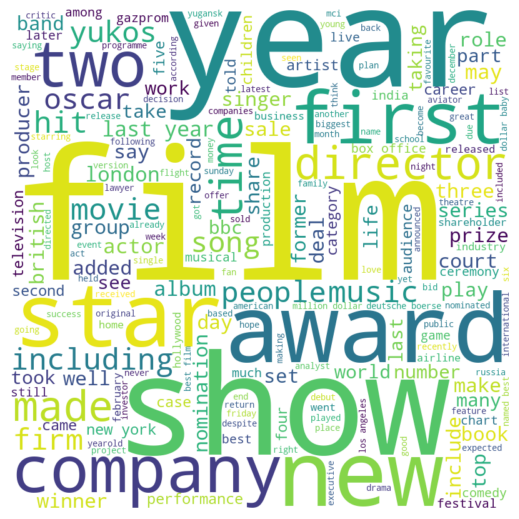

In [120]:
# Topics from group 0
draw_wordcloud(news, 0)

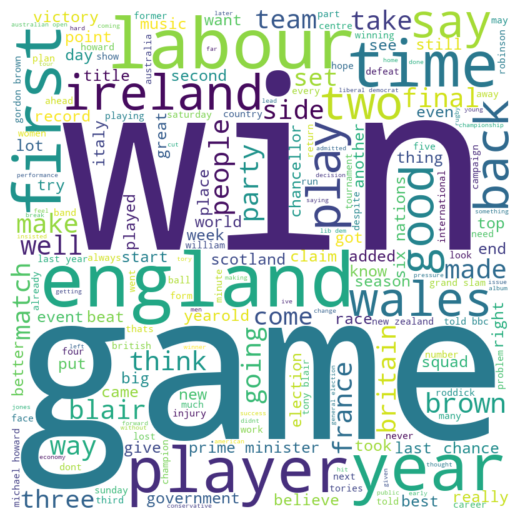

In [121]:
# Topics from group 1
draw_wordcloud(news, 1)

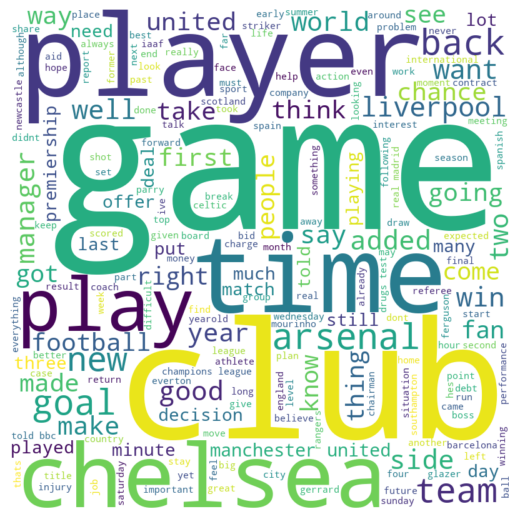

In [122]:
# Topics from group 2
draw_wordcloud(news, 2)

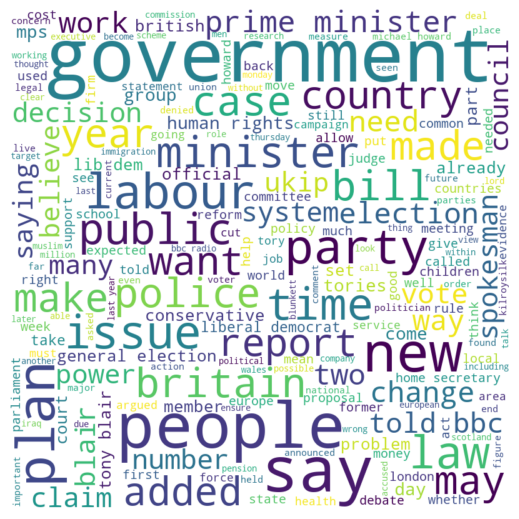

In [123]:
# Topics from group 3
draw_wordcloud(news, 3)

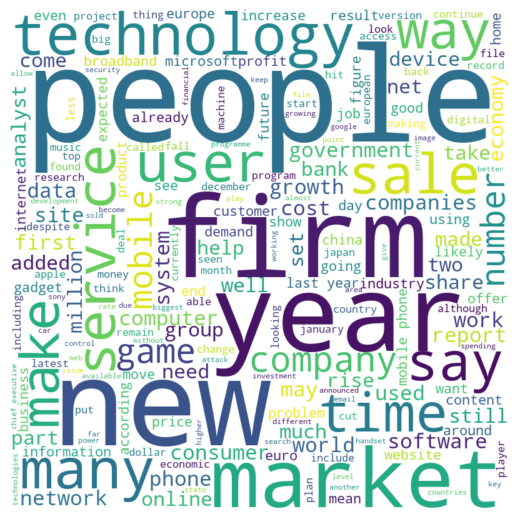

In [124]:
# Topics from group 4
draw_wordcloud(news, 4)